In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import trackpy as tp
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
import random as rand
from tqdm import tqdm
import scipy.stats as stat

In [2]:
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [17]:
#Lets import an arcos set, wave data, and the corresponding tracking data...
base_path = Path.cwd().parent / 'Data Sets/2023_01_24_main-set'
images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'


#There are three important dataframes used in analysis, the wave data frame, the ARCOS df, and the tracking df with binnned calcium values:
#The tracking is the most broad, followed by ARCOS and then the wave (most abstracted info):
wave_dataframe_paths = sorted(analysis_output_destination.glob('*_wave_df.csv'), key=lambda x: x.stem.split('_')[0])
arcos_dataframe_paths = sorted(analysis_output_destination.glob('*_ARCOS_df.csv'), key=lambda x: x.stem.split('_')[0])
tracking_dataframe_paths = sorted(analysis_output_destination.glob('*_tracking_binned_df.csv'), key=lambda x:x.stem.split('_')[0])


In [18]:

wave_speeds = []
img_ids = []
wave_ids = []
min_wave_r = 125

for wave_df_path in tqdm(wave_dataframe_paths):
    #
    wave_df = pd.read_csv(wave_df_path, converters={"wave_centroid": read_tuple_list}) #Open the wave_DF from step4 analysis
    wave_df = wave_df[wave_df.columns.drop(list(wave_df.filter(regex='Unnamed')))] #Strip it of any weird unnamed index columns
    wave_df = wave_df[wave_df['trackable'] == True]
    
    #
    for wid, wave in wave_df.groupby('clTrackID'):
        if wave.circle_radius.max() > min_wave_r:
            wave_speeds.append(np.mean(wave.radius_velocity.values)*60.0)
            img_ids.append(int(wave_df_path.stem.split('_')[0]))
            wave_ids.append(wid)

100%|████████████████████████████████████████████| 57/57 [00:00<00:00, 618.09it/s]


In [5]:

wave_speed_DF = pd.DataFrame({'speed_type':'wave','image_id':img_ids,'wave_id':wave_ids,'mean_speed':wave_speeds})


In [6]:

wave_cell_pop_mean = []
track_min_length = 12 
min_track_time = 48

for a_path, t_path in tqdm(list(zip(arcos_dataframe_paths, tracking_dataframe_paths))):
    #get image number from arcos df 
    im_num = int(a_path.stem.split('_')[0])
    #check that all dfs are the matching image number! 
    if np.all([path_num == im_num for path_num in [int(t_path.stem.split('_')[0])]]):
        #build loop here:
        #Import all DFs associated with an image: 
        arcos_df = pd.read_csv(a_path)
        tracking_df = pd.read_csv(t_path)
        
        #Get image ID, and pull the arcos DFs for the waves analyized in those images: 
        image_id = int(a_path.stem.split('_')[0])
        waves_in_img = wave_speed_DF[wave_speed_DF['image_id'] == image_id].wave_id.values
        arcos_events_from_waves = arcos_df[arcos_df.clTrackID.isin(waves_in_img)]
        
        #Get all tracks, snip off the early frames to not capture cells falling into frame. 
        #group by ID
        tracking_df = tracking_df[tracking_df['timepoint'] > min_track_time]
        tracks = tracking_df.groupby('track_id')
        
        for clID, arcos_wave in arcos_events_from_waves.groupby("clTrackID"):
            
            #get the tracks that arcos says are inside the largest wave...
            track_collect = []

            #Collect all the relevant tracks for the waves in the wave event: 
            for i, track in tracks: 
                if i in arcos_wave.track_id.unique():
                    #Collect the track inside the event, exlcude timepoints before event start
                    track_collect.append(track[track['timepoint'] > arcos_wave.timepoint.min()])

            tracks_in_wave = pd.concat(track_collect, ignore_index=True)

            #Time to calculate some values for all tracks:

            tracks_group = tracks_in_wave.groupby('track_id')
            cell_means = []
            for track_id, track in tracks_group:
                
                if len(track) < track_min_length:
                    continue
                time = track.timepoint.values*5.0
                x_smooth = UnivariateSpline(time, track.x.values, s=12)
                y_smooth = UnivariateSpline(time, track.y.values, s=12)

                #Compile as coords, get the linear velocity vectors, radial vectors, distance from center of the wave, velocity, angle between velocity and center radius, Chemotactic index, and radial velocity:
                coords = np.stack((np.array(x_smooth(time)), np.array(y_smooth(time))), axis=1)
                lin_velocity_vec = [(coords[i+1] - coords[i])/5.0 for i in range(len(coords)-1)]
                velocity = np.linalg.norm(lin_velocity_vec, axis=1)*2.2*60.0 #px/s --> um/s --> um/min
                cell_means.append(np.mean(velocity))

            wave_cell_pop_mean.append(np.mean(cell_means))
            

0it [00:00, ?it/s]


In [7]:

cell_speeds = pd.DataFrame({'speed_type':'cell','mean_speed':wave_cell_pop_mean})

all_speeds_DF = pd.concat([wave_speed_DF,cell_speeds])

In [11]:
#TO SAVE ANALYSIS ABOVE: 
#all_speeds_DF.to_csv('fig1_cell-speed_vs_wave-speed_DF.csv')
#TO LOAD PREV ANALYSIS DONE ABOVE: 
all_speeds_DF = pd.read_csv('fig1_cell-speed_vs_wave-speed_DF.csv')

In [12]:
all_speeds_DF

,Unnamed: 0,speed_type,image_id,wave_id,mean_speed
0,0,wave,27.0,6.0,85.299534
1,1,wave,28.0,2.0,154.351619
2,2,wave,33.0,2.0,108.124328
3,3,wave,33.0,5.0,71.837791
4,4,wave,33.0,19.0,27.244957
...,...,...,...,...,...
245,120,cell,NaN,NaN,7.563680
246,121,cell,NaN,NaN,5.153198
247,122,cell,NaN,NaN,5.904445
248,123,cell,NaN,NaN,8.275758


In [13]:
stat.ttest_ind(all_speeds_DF[all_speeds_DF['speed_type'] == 'cell'].mean_speed.values, all_speeds_DF[all_speeds_DF['speed_type'] == 'wave'].mean_speed.values, equal_var=False)


TtestResult(statistic=-24.399856023371562, pvalue=1.9105575811847208e-49, df=125.3583885845005)

In [14]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})

/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

Text(0, 0.5, '')

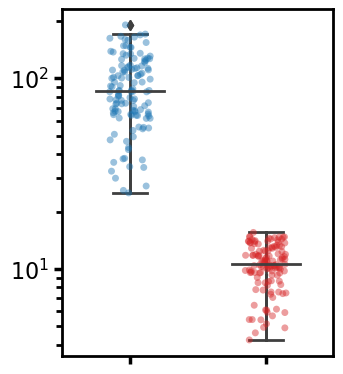

In [15]:
fig, ax = plt.subplots(figsize=(3.5,4.5))
sns.boxplot(data=all_speeds_DF, x='speed_type', y='mean_speed', palette=[sns.color_palette()[0],sns.color_palette()[3]],  width=0.001, ax=ax, zorder=2)
sns.boxplot(data=all_speeds_DF, x='speed_type', y='mean_speed', palette=[sns.color_palette()[0],sns.color_palette()[3]],  showbox=False, width=0.5, ax=ax, zorder=3)
sns.stripplot(data=all_speeds_DF, x='speed_type', y='mean_speed', palette=[sns.color_palette()[0],sns.color_palette()[3]], alpha=0.45, jitter=0.15)
plt.yscale('log')
#plt.ylim(0.5,350)
ax.tick_params(which='major', direction='out', width=2.5, labelsize=16)
ax.tick_params(which='minor', width=2)
#plt.ylim(0,50000)
plt.xlabel('')
plt.xticks([0,1],['',''])
plt.ylabel('')

#TO SAVE FIGURE
#plt.savefig('fig1-wave-v-cell-avg-speed.png', bbox_inches='tight', dpi=300)
